# Ground-State Variational Search with NetKet for a FREE Bosonic Matrix Model

Enrico Rinaldi, March 1, 2022 

In this Tutorial we will use the open-source package [NetKet](https://www.netket.org/) to find the ground state (in a variational sense) of a quantum mechanical system of matrices, which can be seen as a chain of harmonic oscillators.
This system is referred to as a free bosonic matrix model and was studied in [this PRX Quantum paper](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.3.010324).
For this introductory tutorial we set the coupling constant to zero, reducing the system to a set of un-coupled harmonic oscillators. 

Specifically, we will study the system defined by the Hamiltonian: 

$$ \hat{H} = {\rm Tr}\left(\frac{1}{2}\hat{P}_I^2+\frac{m^2}{2}\hat{X}_I^2\right) $$

where 
$$\hat{P}_I=\sum_{\alpha=1}^{N^2-1}\hat{P}_I^\alpha\tau_\alpha$$

and

$$\hat{X}_I=\sum_{\alpha=1}^{N^2-1}\hat{X}_I^\alpha\tau_\alpha$$

for a SU(N) gauge group with $N^2-1$ generators.

## 0. Installing Netket 

Installing NetKet is relatively straightforward. For this Tutorial, if you are running it locally on your machine, we recommend that you create a clean virtual environment (e.g. with `conda`) and install NetKet within (using `pip`): 

```bash
conda create --name netket python pip ipython
conda activate netket
pip install --upgrade netket
```

**If you are on Google Colab**, run the following cell to install the required packages.

In [ ]:
!pip install --upgrade netket

You can check that the installation was succesfull doing 

In [1]:
import netket as nk

You should also check that your version of netket is at least 3.0

In [2]:
print(f"NetKet version: {nk.__version__}")

NetKet version: 3.4.3.dev29+gfe47c195


In [3]:
!python -m netket.tools.info

==         NetKet Diagnostic Informations         ==
NetKet version       : 3.4.3.dev29+gfe47c195

# Python
  - implementation   : CPython
  - version          : 3.10.5
  - distribution     : Clang 13.0.1 
  - path             : /Users/enrythebest/miniforge3/envs/netket-mpi/bin/python

# Host informations
  - System           : macOS-12.4-arm64-arm-64bit
  - Architecture     : arm64
Traceback (most recent call last):
  File "/Users/enrythebest/miniforge3/envs/netket-mpi/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/enrythebest/miniforge3/envs/netket-mpi/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/enrythebest/miniforge3/envs/netket-mpi/lib/python3.10/site-packages/netket/tools/info.py", line 167, in <module>
    info()
  File "/Users/enrythebest/miniforge3/envs/netket-mpi/lib/python3.10/site-packages/netket/tools/info.py", line 81, in info
    platform_info = cpu_inf

In [4]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Position and Momentum space

We can solve the same problem working in position space instead of in the Fock space of the creation and annihilation operators. We first have to change the Hilbert space from a discrete one to a continuous one in `netket`. Then we need to rewrite our Hamiltonian operator using the position and momentum local operators.

Matrix models do not have space, nor they have a "lattice" structure. However, we can interpret the 6 continuous degrees of freedom as 6 different particles in 1 dimension.
For this we can use the abstract `nk.hilbet.Particle`.

In [5]:
import jax.numpy as jnp

# 6 particles in 1 dimension, with infinite extend and no periodic boundary conditions
hi = nk.hilbert.Particle(N=6, L=(jnp.inf), pbc=False)


/Users/enrythebest/miniforge3/envs/netket-mpi/lib/python3.10/site-packages/netket/hilbert/particle.py:52: RuntimeWarning: invalid value encountered in multiply
  if np.any(np.isinf(np.array(L) * np.array(pbc))):
/Users/enrythebest/miniforge3/envs/netket-mpi/lib/python3.10/site-packages/netket/hilbert/continuous_hilbert.py:52: RuntimeWarning: invalid value encountered in multiply
  if np.any(np.isinf(np.array(self._extent) * np.array(self._pbc))):


## 2. Free Hamiltonian in position space

Define the two terms of the Hamiltonian we have in the first equation of this tutorial. The first term is the kinetic energy and the second term is a quadratic "potential" $X_I^2$

In [6]:
def harmonic_potential(x):
    return 0.5 * jnp.linalg.norm(x) ** 2

kinetic_energy = nk.operator.KineticEnergy(hi, mass=1.0)  # the mass is 1.
potential_energy = nk.operator.PotentialEnergy(hi, harmonic_potential)

In [7]:
print(kinetic_energy)

KineticEnergy(m=1.0)


In [8]:
print(potential_energy)

Potential(coefficient=1.0, function+<function harmonic_potential at 0x296c184c0>)


Total Hamiltonian operator

In [9]:
H = kinetic_energy + potential_energy
print(H)

SumOperator(coefficients=[DeviceArray(1., dtype=float64, weak_type=True), DeviceArray(1., dtype=float64)])


## 3. Variational Monte Carlo in continuous space

We define a sampler that will define moves in the continuous space of the "positions" of the "particles". `netket` includes a Gaussian sampler `MetropolisGaussian` where we can choose the "size" of the move by specifying `sigma` 

In [10]:
sampler = nk.sampler.MetropolisGaussian(hi, sigma=0.5, n_chains=4)

We define a model for the wafe function which is just a multivariate Gaussian ansatsz: $\log \psi(x) = -x^{T} \Sigma^{-1} x$ where $\Sigma$ is the (positive-definite) covariance matrix and it is randomly initialized

In [11]:
model = nk.models.Gaussian(param_dtype=float)

Then the VMC proceeds as usual

In [12]:
# define again the variational MC state
vstate = nk.vqs.MCState(sampler, model, n_samples=2**10)

In [13]:
# print the number of parameters
print(f"Number of parameters for this model: {vstate.n_parameters}")

Number of parameters for this model: 36


The kernel is parametrized in such a way to connect the position of each particle to the position of each other particle and itself.

In [14]:
print(vstate.parameters)

FrozenDict({
    kernel: DeviceArray([[ 0.21677428,  0.43701985, -0.75333218,  0.8940846 ,
                   0.26695727,  0.5166806 ],
                 [-0.45726182,  0.15626601,  0.94040605,  1.12703094,
                  -1.76795443, -0.17278205],
                 [-0.50078693, -1.16124061, -0.01588378,  0.03473089,
                   0.14030455,  1.03180224],
                 [ 0.43787483, -0.37188607,  2.23056321,  2.16232334,
                  -0.56764905,  0.5058483 ],
                 [ 0.20691351, -0.23542432, -1.17358517, -0.25613825,
                   0.51154675,  0.97611469],
                 [ 0.07881535, -0.24604217,  0.45798638,  1.51295187,
                   2.2729444 ,  0.07465674]], dtype=float64),
})


Define the optimizer and preconditioner

In [15]:
optimizer = nk.optimizer.Sgd(learning_rate=0.05)

preconditioner = nk.optimizer.SR(diag_shift=0.1)

Define a callback to keep track of the acceptance

In [16]:
# define acceptance logger callback
def cb_acc(step, logged_data, driver):
        logged_data["acceptance"] = float(driver.state.sampler_state.acceptance)
        return True

Then run the VMC

In [17]:
gs = nk.driver.VMC(
    H, optimizer, variational_state=vstate, preconditioner=preconditioner
)

log = nk.logging.RuntimeLog()
gs.run(n_iter=300, out=log, callback=cb_acc)


100%|██████████| 300/300 [00:01<00:00, 219.25it/s, Energy=3.000e+00 ± 4.629e-17 [σ²=9.464e-31, R̂=0.9980]]  


(RuntimeLog():
  keys = ['Energy', 'acceptance'],)

In [18]:
energy = vstate.expect(H)
error = abs((energy.mean - 3.) / 3.)  # the exact energy is 3 because we have 0.5 (energy of 1 particle) *6 (number of particles)
print(f"Optimized energy: {energy} \nRelative error: {error*100:.2f}%")


Optimized energy: 3.000e+00 ± 4.744e-17 [σ²=9.641e-31, R̂=0.9980] 
Relative error: 0.00%


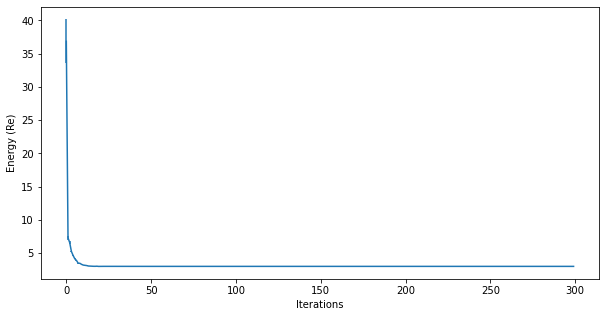

In [19]:
data_cont = log.data
energy_history = data_cont["Energy"]["Mean"].real
energy_error_history = data_cont["Energy"]["Sigma"]

fig, ax = plt.subplots(figsize=(10,5))
ax.errorbar(data_cont["Energy"].iters, energy_history, yerr=energy_error_history)
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy (Re)');

Again we obtain the exact result for the energy, and already after 50 iterations the result has converged. The variance is also very small, but the Gelman-Rubin statistic does not show signs of problems in the sampling. We can look at the sampling acceptance rate

Text(0, 0.5, 'Acc. Rate')

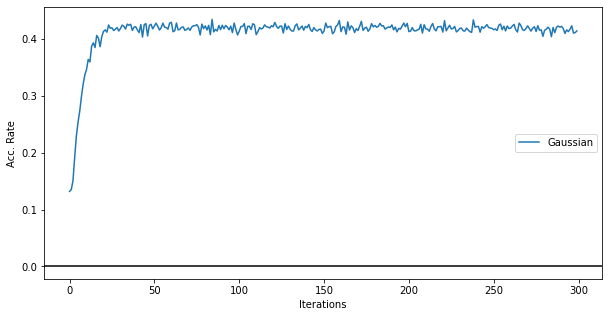

In [20]:
fig, ax = plt.subplots(figsize=(10,5))
ax.errorbar(data_cont["Energy"].iters, data_cont["acceptance"]["value"], label="Gaussian")
ax.axhline(0,c='k')
ax.legend()

ax.set_xlabel('Iterations')
ax.set_ylabel('Acc. Rate')

and we see a 40% acceptance rate across the entire range of iterations. We can also see the individual samples, from the `MetropolisGaussian` algorithm

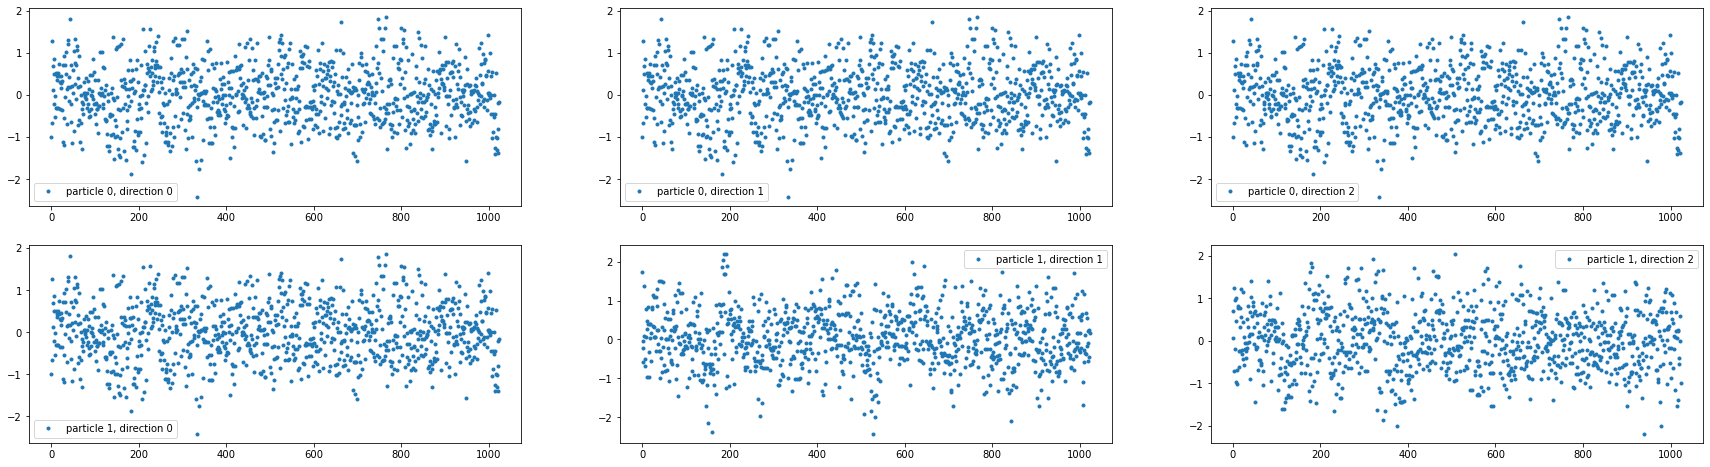

In [21]:
fig, ax = plt.subplots(nrows=2, ncols=3,figsize=(30,8))
for i,axi in enumerate(ax):
    for j,axj in enumerate(axi):
        axj.plot(vstate.samples[:,:,i*j].flatten(), '.', label=f"particle {i}, direction {j}")
        axj.legend()

The ground state can not be transformed to a vector with `to_array()` for the case of a continuous space.

The gaussian ansatz works well because the ground state of the harmonic oscillator is gaussian.

### 4. Changing the ansatz

We can use a fully-connected network as our variational ansatz

In [ ]:
# Flax is a framework to define models using jax
import flax.linen as nn

class FFN(nn.Module):
    
    # You can define attributes at the module-level
    # with a default. This allows you to easily change
    # some hyper-parameter without redefining the whole 
    # flax module. This is the ratio of neurons to input dofs
    alpha : int = 1
            
    @nn.compact
    def __call__(self, x):

        # here we construct the first dense layer using a
        # pre-built implementation in flax.
        # features is the number of output nodes
        dense = nn.Dense(features=self.alpha * x.shape[-1], param_dtype=complex)
        
        # we apply the dense layer to the input
        y = dense(x)

        # the non-linearity is a simple ReLu
        y = nn.relu(y)
        
        # sum the output
        return jnp.sum(y, axis=-1)